In [1]:
# Numerical libraries
import numpy as np   

# Import Linear Regression machine learning library
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import r2_score

# to handle data in form of rows and columns 
import pandas as pd    

# importing ploting libraries
import matplotlib.pyplot as plt   

import statsmodels.formula.api as sm

#importing seaborn for statistical plots
import seaborn as sns

import hashlib
import datetime

# import time
# from datetime import datetime
from time import strftime, gmtime

import statsmodels.formula.api as smf
#maschine learning libraries
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVC
from random import sample



# I'm importing way too much stuff here, will clean it up this weekend!

In [2]:
# read al necessary data 

airports = pd.read_csv('./data/airports.csv', sep=',')
airlines = pd.read_csv('./data/airlines.csv')

# data to test and train on
flights_test = pd.read_csv('./data/flights_test.csv')
flights_train = pd.read_csv('./data/flights_train.csv')

# format on how to submit you results
submit_sample = pd.read_csv('./data/submit_sample.csv')

In [3]:
# again, I'll clean up all the imports of libraries this weekend

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor


flights_train.head()


,id,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY
0,0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,21.0,15.0,205.0,1448,430,-22.0
1,1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,12.0,14.0,280.0,2330,750,-9.0
2,2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,16.0,34.0,286.0,2296,806,5.0
3,3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,15.0,30.0,285.0,2342,805,-9.0
4,4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,11.0,35.0,235.0,1448,320,-21.0


In [4]:
# copied this from your part

unique_origin_airports = flights_train['ORIGIN_AIRPORT'].drop_duplicates()
unique_destination_airports = flights_train['DESTINATION_AIRPORT'].drop_duplicates()

connections = flights_train[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']]
unique_connections = connections.drop_duplicates()

In [5]:
# copied this form your part as well to make sure I'm working with the same formats

def aggregate_date_time(values):
    if(len(values) == 5):
        year, month, day, time, departure = values
        year = int(year)
        month = int(month)
        day = int(day)
        time = int(time)

        hour, minutes = int(time/100), time % 100
        if(hour == 24):
            hour = 0
        dateTime = datetime.datetime(year, month, day, hour, minutes)
        if( dateTime < departure and (departure-dateTime).total_seconds()/60 > 50):
            return dateTime + datetime.timedelta(days=1)
        return dateTime

       
    year, month, day, time = [int(x) for x in values]
    hour, minutes = int(time/100), time % 100
    if(hour == 24):
        hour = 0
    return datetime.datetime(year, month, day, hour, minutes)


def aggregate_time_in_minutes(dateTime):
    return dateTime.hour*60 + dateTime.minute


def preprocessing(x): 
    x['scheduled_departure_date_time'] = x[['YEAR', 'MONTH', 'DAY', 'SCHEDULED_DEPARTURE']].apply(lambda x: aggregate_date_time(x), axis=1)
    x['scheduled_departure_date'] = x['scheduled_departure_date_time'].apply(lambda x: x.date())
    x['scheduled_departure_timestamp'] = x['scheduled_departure_date_time'].apply(lambda x: x.timestamp())
    # x['scheduled_arrival_date_time'] = x[['YEAR', 'MONTH', 'DAY', 'SCHEDULED_ARRIVAL']].apply(lambda x: aggregate_date_time(x), axis=1)
    x['departure_date_time'] = x[['YEAR', 'MONTH', 'DAY', 'DEPARTURE_TIME', 'scheduled_departure_date_time']].apply(lambda x: aggregate_date_time(x), axis=1)
    x['departure_timestamp'] = x['departure_date_time'].apply(lambda x: x.timestamp())
    # x['scheduled_departure_minutes'] = x['scheduled_departure_date_time'].apply(lambda x: aggregate_time_in_minutes(x))
    x['initial_delay'] = (x['departure_date_time'] - x['scheduled_departure_date_time']).apply(lambda x: x.total_seconds() / 60)

    # aggregate mean of initial_delay during day and origin_airport
    delay_at_origin_features = ['ORIGIN_AIRPORT', 'scheduled_departure_date']
    groupedX = x.groupby(delay_at_origin_features).agg({'initial_delay': ['sum', 'mean']})
    groupedX.columns = ['_'.join(column) for column in groupedX.columns]
    x = x.join(groupedX, on=delay_at_origin_features)
    return x



In [6]:
# use functions in case the functions in the code cel above won't transform all values

# flights_train['scheduled_departure_date_time'] = flights_train[['YEAR', 'MONTH', 'DAY', 'SCHEDULED_DEPARTURE']].apply(lambda x: aggregate_date_time(x), axis=1)
# flights_train['scheduled_departure_minutes'] = flights_train['scheduled_departure_date_time'].apply(lambda x: aggregate_time_in_minutes(x))
# flights_train['scheduled_arrival_date_time'] = flights_train[['YEAR', 'MONTH', 'DAY', 'SCHEDULED_ARRIVAL', 'scheduled_departure_date_time']].apply(lambda x: aggregate_date_time(x), axis=1)
# flights_train['departure_date_time'] = flights_train[['YEAR', 'MONTH', 'DAY', 'DEPARTURE_TIME', 'scheduled_departure_date_time']].apply(lambda x: aggregate_date_time(x), axis=1)
# flights_train['initial_delay'] = (flights_train['departure_date_time'] - flights_train['scheduled_departure_date_time']).apply(lambda x: x.total_seconds() / 60)

# Feature Selection
training_set = preprocessing(flights_train)
test_set = preprocessing(flights_test)



<AxesSubplot:xlabel='initial_delay', ylabel='ARRIVAL_DELAY'>

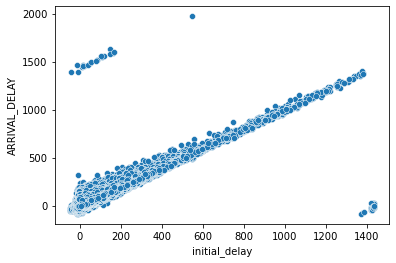

In [7]:
# check whether outcomes are the same

# flights_train[['scheduled_departure_date_time', 'departure_date_time', 'TAXI_OUT', 'WHEELS_OFF', 'initial_delay', 'ARRIVAL_DELAY', 'scheduled_arrival_date_time' ]]
sns.scatterplot(y='ARRIVAL_DELAY', x='initial_delay', data= training_set)

In [8]:
# Group by airline and sum up / count the values
df_flights_grouped_sum = flights_train.groupby('AIRLINE', as_index= False)['ARRIVAL_DELAY'].agg('sum').rename(columns={"ARRIVAL_DELAY":"ARRIVAL_DELAY_SUM"})
df_flights_grouped_cnt = flights_train.groupby('AIRLINE', as_index= False)['ARRIVAL_DELAY'].agg('count').rename(columns={"ARRIVAL_DELAY":"ARRIVAL_DELAY_CNT"})

# Merge the two groups together
df_flights_grouped_delay = df_flights_grouped_sum.merge(df_flights_grouped_cnt, left_on='AIRLINE', right_on='AIRLINE', how='inner')
# Calculate the average delay per airline
df_flights_grouped_delay.loc[:,'AVG_DELAY_AIRLINE'] = df_flights_grouped_delay['ARRIVAL_DELAY_SUM'] / df_flights_grouped_delay['ARRIVAL_DELAY_CNT']

df_flights_grouped_delay.sort_values('ARRIVAL_DELAY_SUM', ascending=False)

,AIRLINE,ARRIVAL_DELAY_SUM,ARRIVAL_DELAY_CNT,AVG_DELAY_AIRLINE
13,WN,3057901.0,610684,5.007338
4,EV,2457505.0,285191,8.617050
10,UA,1938434.0,244880,7.915853
9,OO,1841248.0,285220,6.455536
7,MQ,1769260.0,149746,11.815074
0,AA,1677814.0,256098,6.551453
8,NK,953644.0,54239,17.582256
2,B6,887149.0,127305,6.968689
5,F9,766541.0,42287,18.127108
11,US,719831.0,194223,3.706209


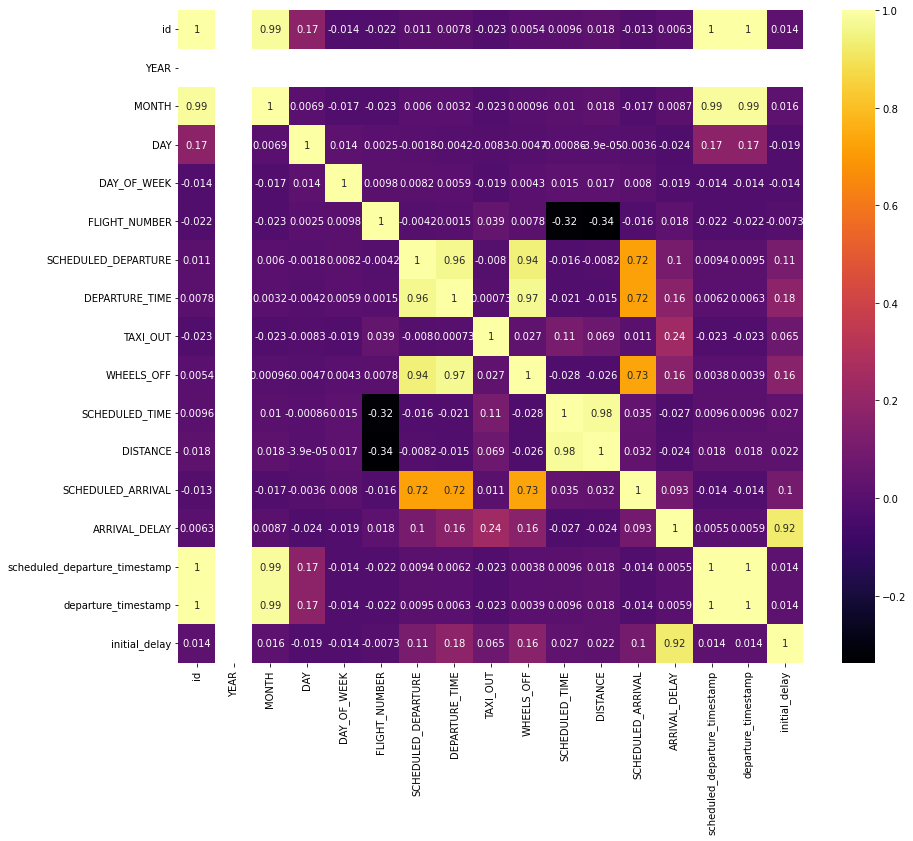

In [9]:
# Dataframe correlation
del_corr = flights_train.corr()

# Draw the figure
f, ax = plt.subplots(figsize=(14, 12))

# Draw the heatmap
sns.heatmap(del_corr,annot=True,cmap='inferno')
plt.show()

Part 1 of which I try to have a look at the most suitable model 

In [70]:
# functions to add margin as a tryout

def delayed_with_margin(value):
    if (value > 35) or (value < -35):
        return True
    else: 
        return False


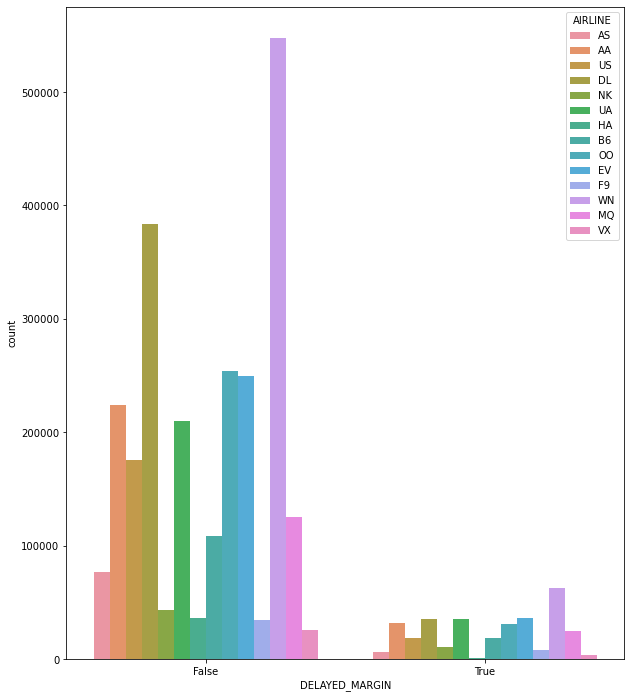

In [72]:
# figure to see difference when adjusting the margin in the code above

figsize=plt.subplots(figsize=(10,12))
sns.countplot(x='DELAYED_MARGIN',hue='AIRLINE',data=flights_train)
plt.show()

# flights_train.info()

In [73]:
# choosing the predictors for further parts

feature_list = [
    # 'ID'
    # 'YEAR'
    # ,'MONTH'
    # ,'DAY'
    # ,'DAY_OF_WEEK'
    # ,'AIRLINE'
    # ,'FLIGHT_NUMBER'
    # ,'TAIL_NUMBER'
    # ,'ORIGIN_AIRPORT'
    # ,'DESTINATION_AIRPORT'
    'SCHEDULED_DEPARTURE'
    ,'SCHEDULED_TIME'
    ,'TAXI_OUT'
    ,'WHEELS_OFF'
    ,'SCHEDULED_TIME'
    ,'DISTANCE'
    ,'SCHEDULED_ARRIVAL'
    ,'ARRIVAL_DELAY'
    ,'scheduled_departure_date_time'
    # ,'scheduled_departure_minutes'
    # ,'scheduled_arrival_date_time'
    ,'departure_date_time'
    ,'initial_delay'
]
# Any number can be used in place of '0'. 
import random
random.seed(0)
    
df_flights_1=flights_train.sample(n=10000)
X = df_flights_1[feature_list]

In [91]:
# X.info()
display(X)

,SCHEDULED_DEPARTURE,SCHEDULED_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,scheduled_departure_date_time,departure_date_time,initial_delay
1292650,2150,45.0,12.0,2213.0,45.0,148,2235,16.0,1.427493e+09,1.427494e+09,11.0
2766334,1835,85.0,27.0,1957.0,85.0,507,2100,70.0,1.435430e+09,1.435433e+09,55.0
2380765,1025,101.0,15.0,1037.0,101.0,533,1106,-6.0,1.433414e+09,1.433413e+09,-3.0
1536589,1100,158.0,17.0,1116.0,158.0,957,1338,-7.0,1.428836e+09,1.428836e+09,-1.0
2269436,1115,64.0,12.0,1118.0,64.0,200,1219,-14.0,1.432812e+09,1.432811e+09,-9.0
...,...,...,...,...,...,...,...,...,...,...,...
785874,1520,110.0,13.0,1538.0,110.0,670,1710,-10.0,1.424705e+09,1.424705e+09,5.0
1228009,640,180.0,9.0,710.0,180.0,977,740,15.0,1.427179e+09,1.427180e+09,21.0
154541,1120,210.0,15.0,1131.0,210.0,1276,1350,-13.0,1.420975e+09,1.420975e+09,-4.0
386622,600,132.0,24.0,613.0,132.0,761,912,-20.0,1.422338e+09,1.422338e+09,-11.0


In [94]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1292650 to 1173452
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SCHEDULED_DEPARTURE            10000 non-null  int64  
 1   SCHEDULED_TIME                 10000 non-null  float64
 2   TAXI_OUT                       10000 non-null  float64
 3   WHEELS_OFF                     10000 non-null  float64
 4   SCHEDULED_TIME                 10000 non-null  float64
 5   DISTANCE                       10000 non-null  int64  
 6   SCHEDULED_ARRIVAL              10000 non-null  int64  
 7   ARRIVAL_DELAY                  10000 non-null  float64
 8   scheduled_departure_date_time  10000 non-null  float64
 9   departure_date_time            10000 non-null  float64
 10  initial_delay                  10000 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 937.5 KB


In [92]:
y = df_flights_1.DELAYED_MARGIN
display(y)

1292650    False
2766334     True
2380765    False
1536589    False
2269436    False
           ...  
785874     False
1228009    False
154541     False
386622     False
1173452    False
Name: DELAYED_MARGIN, Length: 10000, dtype: bool

In [76]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
from sklearn.preprocessing import scale
X_train=scale(X_train)
X_test=scale(X_test)

/Users/rinusvangrunsven/opt/anaconda3/envs/AML/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/rinusvangrunsven/opt/anaconda3/envs/AML/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


In [77]:
model=LinearRegression()
model=model.fit(X_train,y_train)
slope=model.coef_
coef=model.intercept_
print(slope.flatten())
print(coef)

[-6.18303317e-03  6.85035794e+10  2.67431140e-02  2.50167847e-02
 -6.85035794e+10 -4.29449081e-02 -3.11279297e-03  9.58585739e-02
  4.55618486e+11 -4.55623259e+11  2.14010108e+08]
0.11210395590413595


In [78]:
y_pred=model.predict(X_train)

In [79]:
r2_score(y_train,y_pred)

0.5127727161962277

In [80]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression

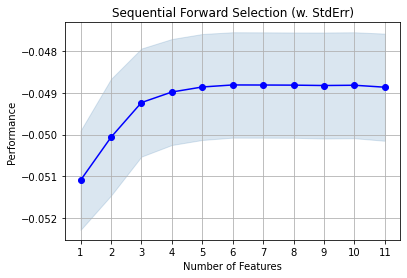

In [81]:
lr = LinearRegression()
sfs = SFS(lr, k_features='best', forward=True, floating=False, 
          scoring='neg_mean_squared_error', cv=10)
model = sfs.fit(X_train, y_train)

fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [82]:
print('Selected features:', sfs.k_feature_idx_)

Selected features: (1, 2, 3, 5, 7, 10)


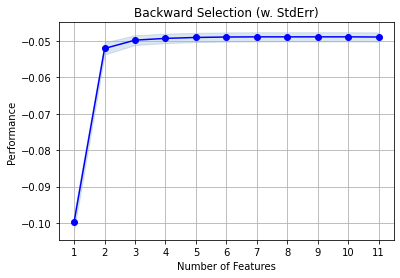

In [83]:
lr = LinearRegression()
sfs2 = SFS(lr, k_features='best', forward=False, floating=False, 
          scoring='neg_mean_squared_error', cv=10)
model = sfs2.fit(X_train, y_train)

fig = plot_sfs(sfs2.get_metric_dict(), kind='std_err')

plt.title('Backward Selection (w. StdErr)')
plt.grid()
plt.show()

In [84]:
print('Selected features:', sfs2.k_feature_idx_)

Selected features: (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)


In [85]:
from sklearn import ensemble,gaussian_process,linear_model,naive_bayes,neighbors,svm,tree

In [86]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostRegressor(),
    ensemble.BaggingRegressor(),
    ensemble.ExtraTreesRegressor(),
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(),
    #Nearest Neighbor
    neighbors.KNeighborsRegressor(),
    #Trees    
    tree.DecisionTreeRegressor(),
    tree.ExtraTreeRegressor()
    ]

In [87]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score,precision_score,recall_score,auc

In [88]:
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)
results=[]

row_index = 0
for alg in MLA:
    
    cv_results = cross_val_score(alg, X_train, y_train, cv=10)
    results.append(cv_results)
    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Train Accuracy'] = round(alg.score(X_train, y_train), 4)
    MLA_compare.loc[row_index, 'MLA Test Accuracy'] = round(alg.score(X_test, y_test), 4)
    MLA_compare.loc[row_index, 'MLA AUC'] = auc(fp, tp)
    
    
    row_index+=1
    
MLA_compare.sort_values(by = ['MLA Test Accuracy'], ascending = False, inplace = True)    
MLA_compare

,MLA Name,MLA Train Accuracy,MLA Test Accuracy,MLA AUC
2,ExtraTreesRegressor,1.000,0.9789,0.999991
0,AdaBoostRegressor,1.000,0.9577,0.981405
1,BaggingRegressor,1.000,0.9577,0.981405
3,GradientBoostingRegressor,1.000,0.9577,0.982456
4,RandomForestRegressor,1.000,0.9577,0.981405
6,DecisionTreeRegressor,1.000,0.9577,0.981405
7,ExtraTreeRegressor,1.000,0.9154,0.968155
5,KNeighborsRegressor,0.851,0.7320,0.944671


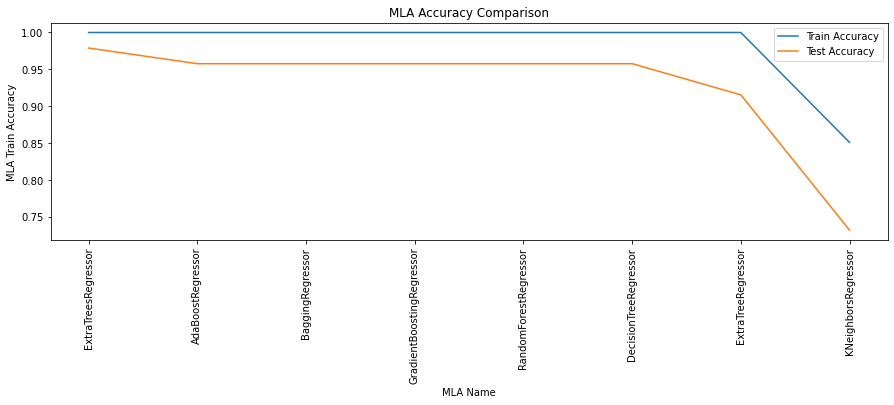

In [89]:
plt.subplots(figsize=(15,4))
sns.lineplot(x="MLA Name", y="MLA Train Accuracy",data=MLA_compare,palette='hot',label='Train Accuracy')
sns.lineplot(x="MLA Name", y="MLA Test Accuracy",data=MLA_compare,palette='hot',label='Test Accuracy')
plt.xticks(rotation=90)
plt.title('MLA Accuracy Comparison')
plt.legend()
plt.show()

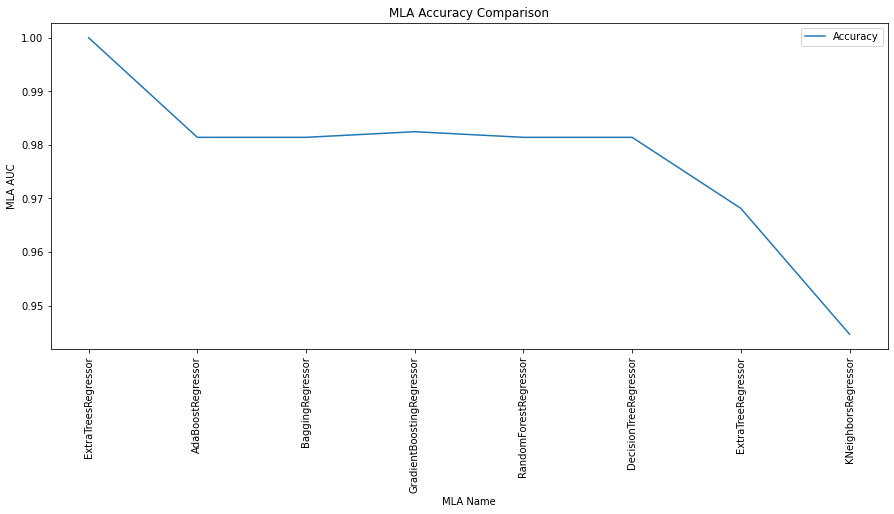

In [90]:
plt.subplots(figsize=(15,6))
sns.lineplot(x="MLA Name", y="MLA AUC",data=MLA_compare,palette='hot',label='Accuracy')

plt.xticks(rotation=90)
plt.title('MLA Accuracy Comparison')
plt.legend()
plt.show()

Part 2 in which I try to have a look at scores of different models

In [96]:
# again, will clean this part 

# importing Various regression algorithms 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso,LinearRegression,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

Las = Lasso()
LinR = LinearRegression()
Rid = Ridge()
Rfc = RandomForestRegressor(random_state=2)
Dtc = DecisionTreeRegressor(random_state = 2)
Boost_Lin = AdaBoostRegressor(base_estimator=LinR,random_state=2)
Boost_las = AdaBoostRegressor(base_estimator=Las,random_state=2)
Boost_rid = AdaBoostRegressor(base_estimator=Rid,random_state=2)
Bg_Lin = BaggingRegressor(base_estimator=LinR,random_state=2)
Bg_las = BaggingRegressor(base_estimator=Las,random_state=2)
Bg_rid = BaggingRegressor(base_estimator=Rid,random_state=2)

In [97]:
le = LabelEncoder()

In [100]:
# Label encoding features to change categorical variables into numerical one
flights_train['AIRLINE']= le.fit_transform(flights_train['AIRLINE'])
flights_train['ORIGIN_AIRPORT'] = le.fit_transform(flights_train['ORIGIN_AIRPORT'])
flights_train['DESTINATION_AIRPORT'] = le.fit_transform(flights_train['DESTINATION_AIRPORT'])
flights_train['DAY'] = le.fit_transform(flights_train['DAY'])
flights_train.info()


In [158]:
# chosing features since I wasn't sure if these would still be working from before

# choosing the predictors
feature_list = [
    # 'ID'
    # 'YEAR'
    # ,'MONTH'
    # ,'DAY'
    # ,'DAY_OF_WEEK'
    # ,'AIRLINE'
    # ,'FLIGHT_NUMBER'
    # ,'TAIL_NUMBER'
    # ,'ORIGIN_AIRPORT'
    # ,'DESTINATION_AIRPORT'
    'SCHEDULED_DEPARTURE'
    ,'SCHEDULED_TIME'
    ,'TAXI_OUT'
    ,'WHEELS_OFF'
    ,'SCHEDULED_TIME'
    ,'DISTANCE'
    ,'SCHEDULED_ARRIVAL'
    # ,'ARRIVAL_DELAY'
    ,'scheduled_departure_date_time'
    # ,'scheduled_departure_minutes'
    # ,'scheduled_arrival_date_time'
    ,'departure_date_time'
    ,'initial_delay'
]
# Any number can be used in place of '0'. 
import random
random.seed(0)
    
df_flights_1=flights_train.sample(n=10000)
X = df_flights_1[feature_list]
display(X)

,SCHEDULED_DEPARTURE,SCHEDULED_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,scheduled_departure_date_time,departure_date_time,initial_delay
1414110,1325,141.0,10.0,1326.0,141.0,657,1546,1.428154e+09,1.428153e+09,-9.0
1572958,1430,119.0,14.0,1436.0,119.0,826,1729,1.429022e+09,1.429021e+09,-8.0
535549,1411,125.0,7.0,1414.0,125.0,764,1716,1.423232e+09,1.423232e+09,-4.0
1926190,1622,112.0,11.0,1633.0,112.0,689,1914,1.430929e+09,1.430929e+09,0.0
2255813,1410,75.0,9.0,1415.0,75.0,283,1525,1.432736e+09,1.432736e+09,-4.0
...,...,...,...,...,...,...,...,...,...,...
1982265,1025,60.0,16.0,1037.0,60.0,166,1125,1.431254e+09,1.431253e+09,-4.0
210967,640,180.0,19.0,709.0,180.0,966,940,1.421304e+09,1.421305e+09,10.0
872827,1524,223.0,11.0,1554.0,223.0,1379,1707,1.425223e+09,1.425225e+09,19.0
2596663,1358,58.0,7.0,1414.0,58.0,139,1456,1.434549e+09,1.434550e+09,9.0


In [160]:
y = df_flights_1.ARRIVAL_DELAY


# y = X['ARRIVAL_DELAY']
y.head()

1414110   -22.0
1572958    -4.0
535549     21.0
1926190     9.0
2255813   -11.0
Name: ARRIVAL_DELAY, dtype: float64

In [161]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state = 2)

In [163]:
sc1=StandardScaler()
X_train_sc=sc1.fit_transform(X_train)
X_test_sc=sc1.transform(X_test)

In [164]:
# found on: https://www.kaggle.com/abhishek211119/2015-flight-delays-and-cancellation-prediction

for model, name in zip([Las,LinR,Rid,Dtc,Rfc,Boost_Lin,Boost_las,Boost_rid,Bg_Lin,Bg_las,Bg_rid], 
     ['Lasso','Linear Regression','Ridge','Random forest Regressor','Decision Tree Regressor','Boosted Linear',
      'Boosted Lasso','Boosted Ridge','Bagged Linear','Bagged Lasso','Bagged Ridge']):
    model1 = model.fit(X_train_sc,y_train)
    Y_predict=model1.predict(X_test_sc)
    print(name)
    print('Mean Absolute Error:', mean_absolute_error(y_test, Y_predict))  
    print('Mean Squared Error:', mean_squared_error(y_test, Y_predict))  
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, Y_predict)))
    print('R2 : ',r2_score(y_test, Y_predict))
    print()

Lasso
Mean Absolute Error: 8.115552111111901
Mean Squared Error: 122.26028452678855
Root Mean Squared Error: 11.057137266344691
R2 :  0.9366520200377354

Linear Regression
Mean Absolute Error: 7.52167048496634
Mean Squared Error: 106.74978361105303
Root Mean Squared Error: 10.331978688085503
R2 :  0.9446886355667906

Ridge
Mean Absolute Error: 7.523256525974239
Mean Squared Error: 106.76586907974274
Root Mean Squared Error: 10.33275708994181
R2 :  0.9446803010372893

Random forest Regressor
Mean Absolute Error: 11.707
Mean Squared Error: 276.747
Root Mean Squared Error: 16.635714592406302
R2 :  0.8566062276194398

Decision Tree Regressor
Mean Absolute Error: 8.181953333333334
Mean Squared Error: 128.88632653333332
Root Mean Squared Error: 11.352811393365668
R2 :  0.9332188006739464

Boosted Linear
Mean Absolute Error: 7.949037615048913
Mean Squared Error: 113.64199654209719
Root Mean Squared Error: 10.660300021204712
R2 :  0.941117502321507

Boosted Lasso
Mean Absolute Error: 8.1792070

Lasso


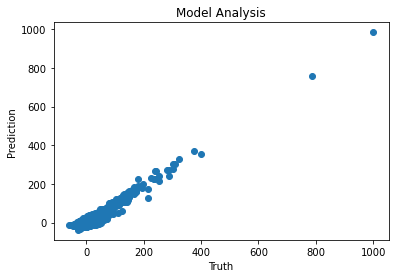

Linear Regression


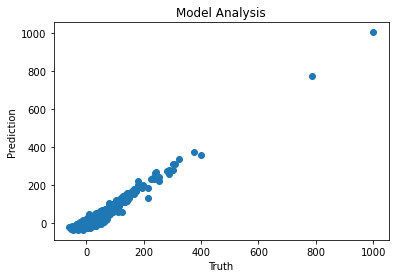

Ridge


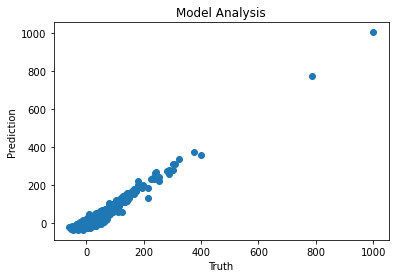

Random forest Regressor


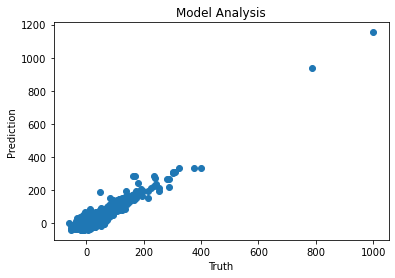

Decision Tree Regressor


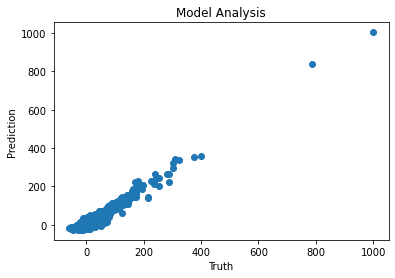

Boosted Linear


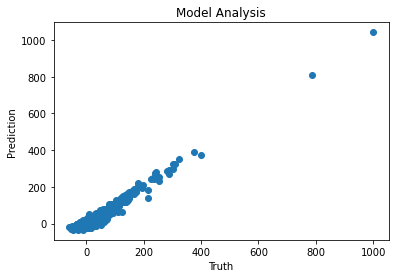

Boosted Lasso


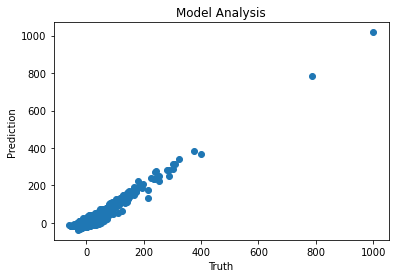

Boosted Ridge


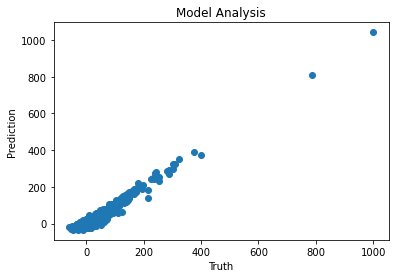

Bagged Linear


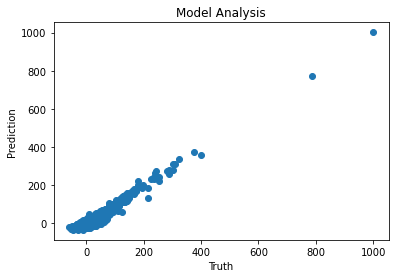

Bagged Lasso


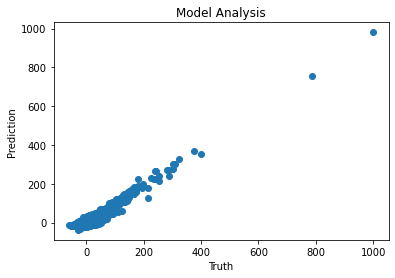

Bagged Ridge


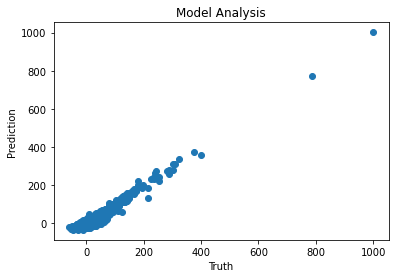

In [165]:
# visualises outcomes

for model, name in zip([Las,LinR,Rid,Dtc,Rfc,Boost_Lin,Boost_las,Boost_rid,Bg_Lin,Bg_las,Bg_rid], 
     ['Lasso','Linear Regression','Ridge','Random forest Regressor','Decision Tree Regressor','Boosted Linear',
      'Boosted Lasso','Boosted Ridge','Bagged Linear','Bagged Lasso','Bagged Ridge']):
    model1 = model.fit(X_train_sc,y_train)
    Y_predict=model1.predict(X_test_sc)
    print(name)
    plt.scatter(y_test, Y_predict)
    plt.title("Model Analysis")
    plt.xlabel("Truth")
    plt.ylabel("Prediction")
    plt.show()